# YouTube QA Chatbot


## 0. Installments

In [49]:
!pip install youtube-transcript-api chromadb pytube
!pip install -q -U langchain langchain-openai langchain-core langchain-community langsmith
!pip install -q openai
!pip install -q rouge-score sacrebleu

## 1. Imports

In [50]:
# Project setup
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse, parse_qs

# Secure access to colab secrets
from google.colab import userdata

# LangChain imports: QA model & additional features
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool, tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage
from langsmith import Client
from langsmith.evaluation import evaluate
from langchain_core.runnables import RunnableLambda
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# YouTube transcript
import re
from youtube_transcript_api import (
    YouTubeTranscriptApi,
    TranscriptsDisabled,
    NoTranscriptFound,
)

# Metadata enrichment
from pytube import YouTube

# Speech recognition
from google.colab import files
from openai import OpenAI
import uuid

# Tools
from collections import defaultdict
from typing import Dict, List

# Deployment
import gradio as gr

# Evaluation
import numpy as np
from rouge_score import rouge_scorer
import sacrebleu

##2. Secure Access

In [51]:
openai_key = userdata.get("OPENAI_API_KEY")
langchain_key = userdata.get("LANGCHAIN_API_KEY")

if openai_key is None:
    raise ValueError("OPENAI_API_KEY not found in Colab secrets.")
if langchain_key is None:
    raise ValueError("LANGCHAIN_API_KEY not found in Colab secrets.")

os.environ["OPENAI_API_KEY"] = openai_key
os.environ["LANGCHAIN_API_KEY"] = langchain_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "youtube-qa-bot"

# Reusable OpenAI client
openai_client = OpenAI()

print("Keys loaded")
print("LangSmith enabled — project:", os.environ["LANGCHAIN_PROJECT"])

Keys loaded
LangSmith enabled — project: youtube-qa-bot


##3. YouTube ingestion

In [52]:
# Extract the YouTube video ID from URL formats
def extract_video_id(url: str) -> str:
    parsed = urlparse(url)

    # In case of short youtu.be links
    if parsed.netloc in ("youtu.be", "www.youtu.be"):
        return parsed.path.lstrip("/")

    # In case of regular youtube.com links
    if parsed.netloc in ("www.youtube.com", "youtube.com", "m.youtube.com"):
        qs = parse_qs(parsed.query)
        vid = qs.get("v", [None])[0]
        if vid:
            return vid

    raise ValueError(f"Could not extract video_id from URL: {url}")

# Convert a transcript (list of {text, start, duration}) to a single text string
def transcript_to_text(transcript, include_timestamps: bool = False) -> str:
    lines = []
    for entry in transcript:
        if include_timestamps:
            start = entry["start"]
            lines.append(f"[{start:.1f}s] {entry['text']}")
        else:
            lines.append(entry["text"])
    return " ".join(lines)


# Fetch transcript for a single video_id and turn it into plain text.
def fetch_transcript_text(video_id: str, languages=None) -> str:
    try:
        ytt_api = YouTubeTranscriptApi()

        if languages is None:
            fetched = ytt_api.fetch(video_id)
        else:
            fetched = ytt_api.fetch(video_id, languages=languages)

        # `fetched` is a FetchedTranscript object with `.snippets`
        # Convert to the same structure transcript_to_text() expects
        transcript = [
            {"text": s.text, "start": s.start, "duration": s.duration}
            for s in fetched.snippets
        ]

        return transcript_to_text(transcript, include_timestamps=False)

    except TranscriptsDisabled:
        raise RuntimeError(f"Transcripts are disabled for video_id={video_id}")
    except NoTranscriptFound:
        raise RuntimeError(f"No transcript found for video_id={video_id} in languages={languages}")
    except Exception as e:
        raise RuntimeError(f"Error fetching transcript for {video_id}: {e}")


In [53]:
# Ingest YouTube videos into a DataFrame
def ingest_youtube_videos(urls, languages=None, save_dir="transcripts"):
    """
    Fetches YouTube transcripts and automatically saves each one as a .txt file.
    If a transcript file already exists locally, it will be loaded instead of calling YouTube again.
    """
    os.makedirs(save_dir, exist_ok=True)
    rows = []
    for url in urls:
        video_id = extract_video_id(url)
        txt_path = os.path.join(save_dir, f"{video_id}.txt")
        # Load local transcript if available
        if os.path.exists(txt_path):
            print(f"Loading saved transcript for {video_id}")
            with open(txt_path, "r", encoding="utf-8") as f:
                transcript = f.read()
        else:
            # Fetch from YouTube
            try:
                print(f"Fetching transcript from YouTube for {video_id}...")
                transcript = fetch_transcript_text(video_id, languages=languages)
                # Save to .txt
                with open(txt_path, "w", encoding="utf-8") as f:
                    f.write(transcript)
                print(f"Transcript saved at {txt_path}")
            except Exception as e:
                print(f"Skipping {url}: {e}")
                transcript = ""
        rows.append({
            "video_id": video_id,
            "url": url,
            "transcript": transcript,
        })
    return pd.DataFrame(rows)

In [54]:
def load_local_transcripts(urls, save_dir="transcripts"):
    rows = []
    for url in urls:
        video_id = extract_video_id(url)
        txt_path = os.path.join(save_dir, f"{video_id}.txt")
        if not os.path.exists(txt_path):
            print(f"No local transcript found for {video_id}")
            transcript = ""
        else:
            print(f"Loading local transcript for {video_id}")
            with open(txt_path, "r", encoding="utf-8") as f:
                transcript = f.read()
        rows.append({
            "video_id": video_id,
            "url": url,
            "transcript": transcript,
        })
    return pd.DataFrame(rows)

In [55]:
# Ingesting multiple videos
video_urls = [
    "https://www.youtube.com/watch?v=a43Je1KQY3s", # What is ATS?
    "https://www.youtube.com/watch?v=ck5nw7R1uEs", # FAANG Interview
    "https://www.youtube.com/watch?v=jXXOI01IuPs", # What is happening in big tech interviews 2025
    "https://www.youtube.com/watch?v=YUL8ayPe1r8", # Outdated resume experience
    "https://www.youtube.com/watch?v=pjqi_M3SPwY", # Resume mistakes to avoid
    "https://www.youtube.com/watch?v=mmQcX6HpCGs", # Interview
    "https://www.youtube.com/watch?v=dG3TdJn7JP4", # Interview
    "https://www.youtube.com/watch?v=WdyiUe7_3cA", # Interview
    "https://www.youtube.com/watch?v=m-pjMa43tho", # Interview
    "https://www.youtube.com/watch?v=8OOvvJ0hd3M"  # Interview
]

df_videos = ingest_youtube_videos(video_urls, languages=["en", "de"], save_dir="transcripts"
)

if df_videos.empty:
    print("No videos ingested ...")
else:
    print(df_videos.head())

Loading saved transcript for a43Je1KQY3s
Loading saved transcript for ck5nw7R1uEs
Loading saved transcript for jXXOI01IuPs
Loading saved transcript for YUL8ayPe1r8
Loading saved transcript for pjqi_M3SPwY
Loading saved transcript for mmQcX6HpCGs
Loading saved transcript for dG3TdJn7JP4
Loading saved transcript for WdyiUe7_3cA
Loading saved transcript for m-pjMa43tho
Loading saved transcript for 8OOvvJ0hd3M
      video_id                                          url  \
0  a43Je1KQY3s  https://www.youtube.com/watch?v=a43Je1KQY3s   
1  ck5nw7R1uEs  https://www.youtube.com/watch?v=ck5nw7R1uEs   
2  jXXOI01IuPs  https://www.youtube.com/watch?v=jXXOI01IuPs   
3  YUL8ayPe1r8  https://www.youtube.com/watch?v=YUL8ayPe1r8   
4  pjqi_M3SPwY  https://www.youtube.com/watch?v=pjqi_M3SPwY   

                                          transcript  
0  hey does your resume feel outdated or invisibl...  
1  3 million that is the number of rums Google re...  
2  Something strange is happening with tech in

## 4. Build dataset of videos

In [ ]:
# 1. Open a file upload dialog (you can select all 10 .txt files at once)
uploaded = files.upload()

# 2. Read each uploaded file and store its contents in a dictionary
texts = {}

for filename, raw_data in uploaded.items():
    # raw_data is binary → decode to UTF-8 text
    texts[filename] = raw_data.decode('utf-8')

# 3. Print a list of successfully loaded files
print("Loaded files:")
for name in texts:
    print(" -", name)


Saving 8OOvvJ0hd3M.txt to 8OOvvJ0hd3M (1).txt
Saving a43Je1KQY3s.txt to a43Je1KQY3s (1).txt
Saving ck5nw7R1uEs.txt to ck5nw7R1uEs (1).txt
Saving dG3TdJn7JP4.txt to dG3TdJn7JP4 (1).txt
Saving jXXOI01IuPs.txt to jXXOI01IuPs (1).txt
Saving mmQcX6HpCGs.txt to mmQcX6HpCGs (1).txt
Saving m-pjMa43tho.txt to m-pjMa43tho (1).txt
Saving pjqi_M3SPwY.txt to pjqi_M3SPwY (1).txt
Saving WdyiUe7_3cA.txt to WdyiUe7_3cA (1).txt
Saving YUL8ayPe1r8.txt to YUL8ayPe1r8 (1).txt
Loaded files:
 - 8OOvvJ0hd3M (1).txt
 - a43Je1KQY3s (1).txt
 - ck5nw7R1uEs (1).txt
 - dG3TdJn7JP4 (1).txt
 - jXXOI01IuPs (1).txt
 - mmQcX6HpCGs (1).txt
 - m-pjMa43tho (1).txt
 - pjqi_M3SPwY (1).txt
 - WdyiUe7_3cA (1).txt
 - YUL8ayPe1r8 (1).txt


Data Cleaning

In [56]:


def clean_transcript(text: str) -> str:
    if not text:
        return ""

    # 1. Remove timestamps
    text = re.sub(r'\[\d{1,2}:\d{2}(?::\d{2})?\]', ' ', text)

    # 2. Remove noise tags
    noise_tags = [
        r'\[music\]', r'\[applause\]', r'\[laughter\]',
        r'\[silence\]', r'\[background noise\]'
    ]
    for tag in noise_tags:
        text = re.sub(tag, ' ', text, flags=re.IGNORECASE)

    # 3. Remove filler words
    fillers = [
        r"\bum\b", r"\buh\b", r"\bumm\b",
        r"\ber\b", r"\bem\b", r"\buhh\b",
        r"\byou know\b", r"\bkind of\b", r"\bsort of\b",
    ]
    for filler in fillers:
        text = re.sub(filler, ' ', text, flags=re.IGNORECASE)

    return text


In [57]:
id_to_text = {}

for filename, content in texts.items():
    # remove .txt
    base = filename[:-4] if filename.endswith(".txt") else filename
    # remove "(1)", "(2)" suffixes
    base = re.sub(r"\ \(\d+\)$", "", base)
    video_id = base

    cleaned = clean_transcript(content)

    id_to_text[video_id] = cleaned

print("Cleaned video_ids from filenames:")
for vid in id_to_text.keys():
    print(" -", vid)


Cleaned video_ids from filenames:
 - 8OOvvJ0hd3M
 - a43Je1KQY3s
 - ck5nw7R1uEs
 - dG3TdJn7JP4
 - jXXOI01IuPs
 - mmQcX6HpCGs
 - m-pjMa43tho
 - pjqi_M3SPwY
 - WdyiUe7_3cA
 - YUL8ayPe1r8


In [58]:
rows = []

for url in video_urls:
    video_id = extract_video_id(url)
    transcript = id_to_text.get(video_id, "")
    if not transcript:
        print(f"Warning: no transcript found for video_id={video_id}")
    rows.append({
        "video_id": video_id,
        "url": url,
        "transcript": transcript,
    })

df_videos = pd.DataFrame(rows)
df_videos.head()


,video_id,url,transcript
0,a43Je1KQY3s,https://www.youtube.com/watch?v=a43Je1KQY3s,hey does your resume feel outdated or invisibl...
1,ck5nw7R1uEs,https://www.youtube.com/watch?v=ck5nw7R1uEs,3 million that is the number of rums Google re...
2,jXXOI01IuPs,https://www.youtube.com/watch?v=jXXOI01IuPs,Something strange is happening with tech inter...
3,YUL8ayPe1r8,https://www.youtube.com/watch?v=YUL8ayPe1r8,Your resume isn't working because you're follo...
4,pjqi_M3SPwY,https://www.youtube.com/watch?v=pjqi_M3SPwY,all right so when I was applying to my first f...


##5. Chunking + LangChain Documents

Prepare test data & tools for chunk size testing

In [59]:
# ============================================
# Cell 1: Evaluation setup
# ============================================

from typing import List, Dict
import numpy as np
from langchain_openai import OpenAIEmbeddings

# Embeddings used ONLY for answer similarity scoring
eval_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Cosine similarity helper
def cosine_sim(a, b) -> float:
    a = np.array(a)
    b = np.array(b)
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

# Your evaluation questions
# 👉 Put your original questions/expected answers here to get comparable results
test_questions: List[Dict[str, str]] = [
    {
        "question": "What is an ATS?",
        "expected": "ATS stands for Applicant Tracking System, software used to manage and filter job applications."
    },
    {
        "question": "What should be avoided on a resume?",
        "expected": "Avoid overly designed formats, graphics, tables, and elements that confuse ATS systems."
    },
    # Add the rest of your original questions here
]

print(f"Prepared {len(test_questions)} test questions.")

# Chunk sizes and overlap to test
chunk_sizes_to_test = [1000, 1500,1700, 1800, 2000]
test_overlap = 150
print("Testing chunk sizes:", chunk_sizes_to_test, "with overlap:", test_overlap)


Prepared 2 test questions.
Testing chunk sizes: [1000, 1500, 1700, 1800, 2000] with overlap: 150


Run the test

In [60]:

# Cell 2: comprehensive_chunk_test (self-contained)

def comprehensive_chunk_test(
    df,
    chunk_size: int,
    overlap: int,
    test_data: List[Dict[str, str]],
):
    """
    Tests a given chunk size across:
      - retrieval_quality  (term overlap heuristic)
      - answer_quality     (embedding cosine similarity)
      - avg_context_length (size of retrieved chunks)
    This function is self-contained: it does its own chunking and vectorstore building.
    """

    print(f"\nBuilding vectorstore with chunk size {chunk_size}...")

    # ---------- 1) CHUNKING HAPPENS HERE ----------
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        length_function=len,
    )

    docs: List[Document] = []
    for _, row in df.iterrows():
        transcript = row.get("transcript", "") or ""
        # keep everything except transcript as metadata
        metadata = {col: row[col] for col in df.columns if col != "transcript"}
        chunks = splitter.split_text(transcript)

        for idx, chunk in enumerate(chunks):
            md = dict(metadata)
            md["chunk_index"] = idx
            docs.append(Document(page_content=chunk, metadata=md))

    # ---------- 2) VECTORSTORE BUILDING HAPPENS HERE ----------
    # (separate embeddings instance from eval_embeddings on purpose)
    from langchain_openai import OpenAIEmbeddings as VSOpenAIEmbeddings
    vs_embeddings = VSOpenAIEmbeddings(model="text-embedding-3-small")

    vectorstore = Chroma.from_documents(
        documents=docs,
        embedding=vs_embeddings,
        collection_name=f"test_{chunk_size}",
        persist_directory=None,  # in-memory
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

    retrieval_scores = []
    answer_similarities = []
    context_lengths = []

    # ---------- 3) LOOP OVER TEST QUESTIONS ----------
    for idx, item in enumerate(test_data):
        question = item["question"]
        expected = item["expected"]

        # --- Retrieval ---
        retrieved_docs = retriever.invoke(question)

        # simple retrieval heuristic: term overlap
        terms = [t for t in question.lower().split() if len(t) > 3]
        context_text = " ".join(d.page_content.lower() for d in retrieved_docs)
        matches = sum(1 for t in terms if t in context_text)
        retrieval_score = matches / max(len(terms), 1)
        retrieval_scores.append(retrieval_score)

        # context length
        if retrieved_docs:
            context_lengths.append(
                np.mean([len(d.page_content) for d in retrieved_docs])
            )
        else:
            context_lengths.append(0)

        # --- LLM answer ---
        context = "\n\n".join(d.page_content for d in retrieved_docs)
        prompt = (
            "You must answer based ONLY on the following transcript snippets.\n\n"
            f"Context:\n{context}\n\n"
            f"Question: {question}\n\n"
            "Answer concisely:"
        )
        answer = llm.invoke(prompt).content

        # --- Answer quality (semantic similarity) ---
        expected_vec = eval_embeddings.embed_query(expected)
        answer_vec = eval_embeddings.embed_query(answer)
        similarity = cosine_sim(expected_vec, answer_vec)
        answer_similarities.append(similarity)

        print(f"Tested question {idx + 1}/{len(test_data)}")

    # ---------- 4) AGGREGATED METRICS ----------
    return {
        "chunk_size": chunk_size,
        "num_chunks": len(docs),
        "retrieval_quality": float(np.mean(retrieval_scores)),
        "answer_quality": float(np.mean(answer_similarities)),
        "avg_context_length": float(np.mean(context_lengths)),
    }


In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,  # 0.0 for deterministic evaluation
)

all_results: List[Dict] = []

for size in chunk_sizes_to_test:
    print("\n" + "=" * 60)
    print(f"Testing chunk size: {size}")
    print("=" * 60)

    result = comprehensive_chunk_test(
        df_videos,
        chunk_size=size,
        overlap=test_overlap,
        test_data=test_questions
    )

    all_results.append(result)

# ============================================================
# Print summary of results
# ============================================================

print("\n" + "=" * 60)
print("SUMMARY OF ALL TESTS")
print("=" * 60)

for result in all_results:
    print(f"\nChunk Size: {result['chunk_size']}")
    print(f"  Number of chunks: {result['num_chunks']}")
    print(f"  Retrieval quality: {result['retrieval_quality']:.3f}")
    print(f"  Answer quality: {result['answer_quality']:.3f}")
    print(f"  Avg context length: {result['avg_context_length']:.1f}")



Testing chunk size: 1000

Building vectorstore with chunk size 1000...
Tested question 1/2
Tested question 2/2

Testing chunk size: 1500

Building vectorstore with chunk size 1500...


Visualize test results

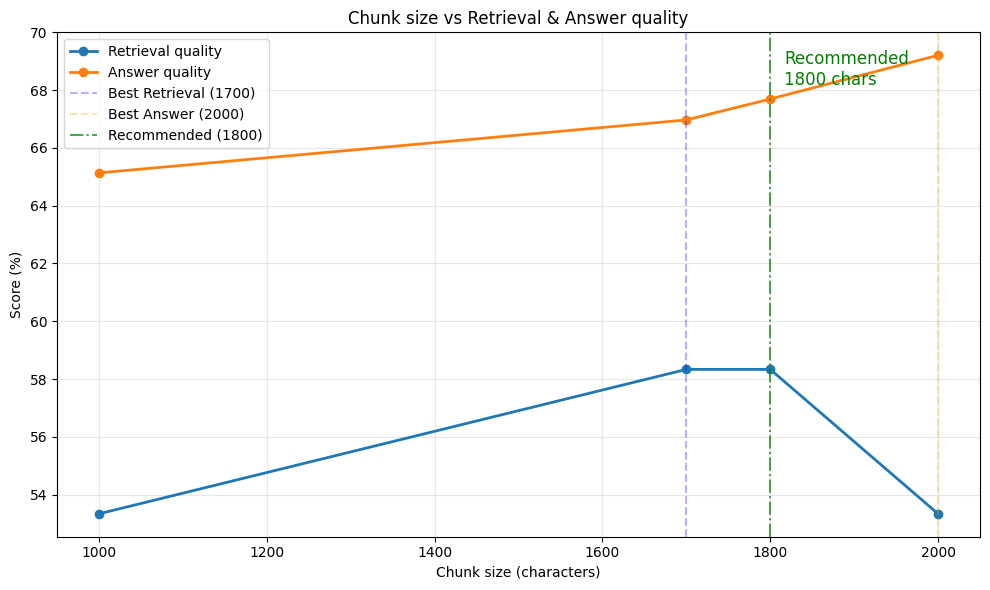

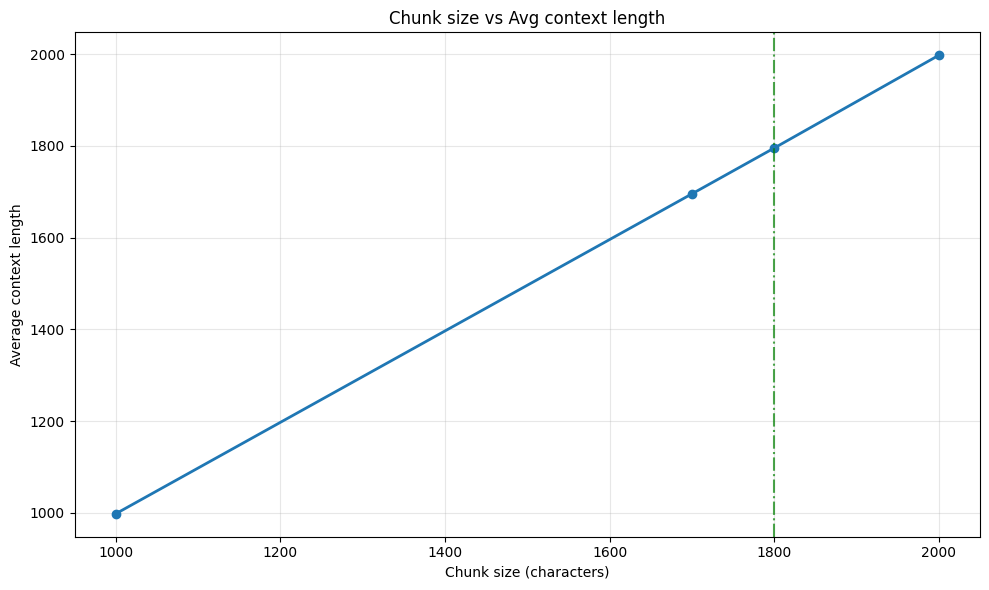

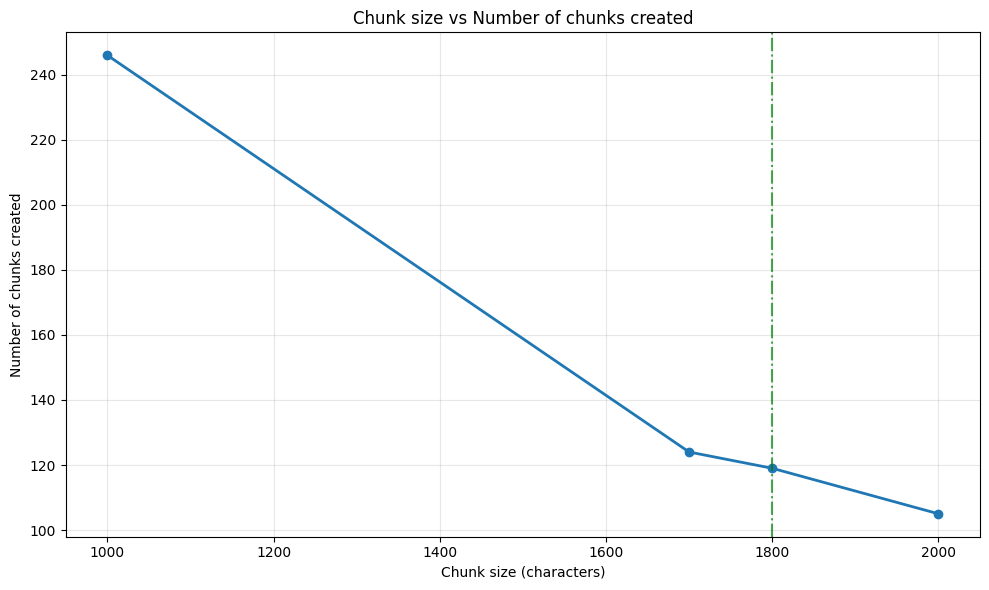

In [ ]:

# Analyze and plot chunk-size results

# --- Convert results to DataFrame ---
df_results = pd.DataFrame(all_results)
df_results["retrieval_pct"] = df_results["retrieval_quality"] * 100
df_results["answer_pct"] = df_results["answer_quality"] * 100

# --- Compute best chunk sizes (using same metrics as before) ---

# Best by retrieval and answer quality
best_retrieval_row = df_results.loc[df_results["retrieval_quality"].idxmax()]
best_answer_row = df_results.loc[df_results["answer_quality"].idxmax()]

best_chunk_retrieval = int(best_retrieval_row["chunk_size"])
best_chunk_answer = int(best_answer_row["chunk_size"])

# Overall score: 30% retrieval, 70% answer
overall_scores = (
    0.3 * df_results["retrieval_quality"] + 0.7 * df_results["answer_quality"]
)
best_overall_idx = overall_scores.idxmax()
best_chunk_overall = int(df_results.loc[best_overall_idx, "chunk_size"])

# --- Plot 1: Retrieval & Answer Quality vs. chunk size ---
plt.figure(figsize=(10, 6))

plt.plot(
    df_results["chunk_size"],
    df_results["retrieval_pct"],
    marker="o",
    label="Retrieval quality",
    linewidth=2,
)
plt.plot(
    df_results["chunk_size"],
    df_results["answer_pct"],
    marker="o",
    label="Answer quality",
    linewidth=2,
)

# Highlight best points
plt.axvline(
    best_chunk_retrieval,
    color="blue",
    linestyle="--",
    alpha=0.3,
    label=f"Best Retrieval ({best_chunk_retrieval})",
)
plt.axvline(
    best_chunk_answer,
    color="orange",
    linestyle="--",
    alpha=0.3,
    label=f"Best Answer ({best_chunk_answer})",
)
plt.axvline(
    best_chunk_overall,
    color="green",
    linestyle="-.",
    alpha=0.7,
    label=f"Recommended ({best_chunk_overall})",
)

# Annotate the recommended point
best_row = df_results[df_results["chunk_size"] == best_chunk_overall].iloc[0]
plt.annotate(
    f"Recommended\n{best_chunk_overall} chars",
    (best_chunk_overall, best_row["answer_pct"]),
    textcoords="offset points",
    xytext=(10, 10),
    ha="left",
    color="green",
    fontsize=12,
)

plt.xlabel("Chunk size (characters)")
plt.ylabel("Score (%)")
plt.title("Chunk size vs Retrieval & Answer quality")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Avg Context Length vs. chunk size ---
plt.figure(figsize=(10, 6))
plt.plot(
    df_results["chunk_size"],
    df_results["avg_context_length"],
    marker="o",
    linewidth=2,
)
plt.axvline(
    best_chunk_overall,
    color="green",
    linestyle="-.",
    alpha=0.7,
)

plt.xlabel("Chunk size (characters)")
plt.ylabel("Average context length")
plt.title("Chunk size vs Avg context length")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 3: Number of chunks vs. chunk size ---
plt.figure(figsize=(10, 6))
plt.plot(
    df_results["chunk_size"],
    df_results["num_chunks"],
    marker="o",
    linewidth=2,
)
plt.axvline(
    best_chunk_overall,
    color="green",
    linestyle="-.",
    alpha=0.7,
)

plt.xlabel("Chunk size (characters)")
plt.ylabel("Number of chunks created")
plt.title("Chunk size vs Number of chunks created")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Actual chunking

In [ ]:
# Convert each row in df_videos (video_id, url, transcript) into multiple LangChain Documents with metadata.
def df_to_documents(
    df: pd.DataFrame,
    chunk_size: int = 1600,
    chunk_overlap: int = 250,
) -> list[Document]:
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
    )

    docs: list[Document] = []

    for _, row in df.iterrows():
        video_id = row["video_id"]
        url = row["url"]
        transcript = row["transcript"] or ""

        # Try to fetch metadata from YouTube
        title = author = description = None
        try:
            yt = YouTube(url)
            title = yt.title
            author = yt.author
            description = yt.description
        except Exception:
            pass

        # Split transcript into chunks
        chunks = splitter.split_text(transcript)

        for idx, chunk in enumerate(chunks):
            doc = Document(
                page_content=chunk,
                metadata={
                    "video_id": video_id,
                    "url": url,
                    "title": title or f"Video {video_id}",
                    "author": author or "Unknown",
                    "description": description or "",
                    "chunk_index": idx,
                },
            )
            docs.append(doc)

    return docs


In [ ]:
# add LangChain Documents on top the DataFrame
documents = df_to_documents(df_videos)
print(f"Created {len(documents)} chunks from {len(df_videos)} videos.")

Created 119 chunks from 10 videos.


##6. Build a LangChain VectorStore (Chroma)

In [ ]:
# Build vectorstore from Documents
def build_vectorstore_from_documents(
    docs: list[Document],
    collection_name: str = "youtube_rag",
    persist_directory: str | None = None,
):
    """
    Build a Chroma vector store from LangChain Documents.
    Uses OpenAI embeddings by default.
    """
    # OpenAI embedding model
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    vectorstore = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=persist_directory,  # can be None for in-memory
    )
    return vectorstore

In [ ]:
vectorstore = build_vectorstore_from_documents(
    documents,
    collection_name="youtube_rag",
    persist_directory="./chroma_youtube_rag",
)

##7. LLM + Retriever + Memory

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

memory = ChatMessageHistory()

rag_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant answering questions about the content "
            "of YouTube videos indexed in a vector database. "
            "Use the retrieved context to answer accurately."
        ),
        ("human", "Context from videos:\n{context}\n\nQuestion: {question}")
    ]
)

##8. RAG pipeline

In [ ]:
def youtube_rag_query(question: str):
    """
    Full RAG pipeline:
    1. Retrieve relevant video chunks
    2. Add them into the prompt
    3. Call the LLM
    4. Store chat history (memory)
    """
    # Retrieval
    docs = retriever.invoke(question)

    if not docs:
        context = "No relevant content found."
    else:
        context_parts = []
        for i, d in enumerate(docs):
            meta = d.metadata or {}
            context_parts.append(
                f"[{i+1}] Title: {meta.get('title', 'Unknown')}\n"
                f"Channel: {meta.get('author', 'Unknown')}\n"
                f"Description: {meta.get('description', 'No description')}\n"
                f"Chunk {meta.get('chunk_index', '?')}:\n{d.page_content}"
            )
        context = "\n\n---\n".join(context_parts)

    # Build prompt
    prompt_msg = rag_prompt.format_messages(
        context=context,
        question=question,
    )

    # LLM call
    response = llm.invoke(prompt_msg)

    # Memory update
    memory.add_message(HumanMessage(content=question))
    memory.add_message(response)

    return response.content, context


##9. Tools & Agent with Personality

In [ ]:
# Personality configuration
PERSONALITY = (
    "Friendly, encouraging, and concise. "
    "Explain things clearly and avoid jargon. "
    "If the user sounds stressed or insecure, be extra supportive."
)

# Tools

@tool
def youtube_rag_qa(question: str) -> str:
    """Answer questions about the YouTube videos that have been ingested into the vector store."""
    answer, _ctx = youtube_rag_query(question)
    return answer

@tool
def transcribe_audio_file(audio_path: str) -> str:
    """Transcribe an audio file at a local path to text."""
    return transcribe_audio_to_text(audio_path)

tools = [youtube_rag_qa, transcribe_audio_file]
tool_map = {t.name: t for t in tools}

# LLM that can call tools
tool_llm = llm.bind_tools(tools)

# Conversation memory (per session)
session_history: Dict[str, List[BaseMessage]] = defaultdict(list)

BASE_SYSTEM_PROMPT = (
    "You are an assistant that answers questions about a set of YouTube videos "
    "that have already been ingested into a vector database.\n"
    "If the user asks about the content of the videos, you should use the "
    "`youtube_rag_qa` tool.\n"
    "If the user gives or refers to an audio file path, you can use the "
    "`transcribe_audio_file` tool to turn it into text and then use "
    "`youtube_rag_qa` with the transcribed question.\n"
    "Always give concise, helpful answers."
)

def build_system_prompt() -> str:
    """Combine base instructions with the current personality."""
    if PERSONALITY:
        return BASE_SYSTEM_PROMPT + f"\n\nPersonality & tone: {PERSONALITY}"
    return BASE_SYSTEM_PROMPT

def agent_chat(user_input: str, session_id: str = "default") -> str:
    """
    Simple agent:
    - Uses OpenAI tool-calling to decide whether to call youtube_rag_qa / transcribe_audio_file
    - Keeps per-session memory of previous turns
    - Applies the configured personality on top of the base system prompt
    """
    history = session_history[session_id]

    # Build the message list: system + history + new user message
    messages: List[BaseMessage] = [
        SystemMessage(content=build_system_prompt()),
        *history,
        HumanMessage(content=user_input),
    ]

    # First model call: the model may decide to call tools
    ai_msg = tool_llm.invoke(messages)
    messages.append(ai_msg)

    # If the model already answered without tools, just return that
    if not getattr(ai_msg, "tool_calls", None):
        history.extend([HumanMessage(content=user_input), ai_msg])
        return ai_msg.content

    # If there are tool calls, execute them
    tool_messages: List[ToolMessage] = []
    for call in ai_msg.tool_calls:
        tool_name = call["name"]
        tool_args = call["args"]
        tool_id = call["id"]

        tool = tool_map.get(tool_name)
        if tool is None:
            tool_result = f"Error: tool '{tool_name}' not found."
        else:
            # invoke() expects a dict of arguments for the tool
            tool_result = tool.invoke(tool_args)

        tool_messages.append(
            ToolMessage(
                content=str(tool_result),
                tool_call_id=tool_id,
            )
        )

    # Second model call: model sees tool results and produces final answer
    messages.extend(tool_messages)
    final_ai = llm.invoke(messages)

    # Update history with just the human input and final answer
    history.extend([
        HumanMessage(content=user_input),
        final_ai,
    ])

    return final_ai.content


In [ ]:
# test the pipeline
answer, used_context = youtube_rag_query("Give me an overview of the videos you indexed.")

print("=== ANSWER ===\n")
print(answer)

print("\n=== CONTEXT USED ===\n")
print(used_context)

=== ANSWER ===

The indexed videos primarily focus on interview preparation and the use of AI tools to enhance the interview experience for candidates. 

1. **Video jXXOI01IuPs**: This video discusses the importance of having a centralized platform for interview preparation, particularly for tech companies. It highlights features such as AI-powered mock interviews that adapt to the user's skill level, a company-specific question bank that tracks current interview trends at major companies like Google, Meta, and Amazon, and an AI coding assistant for practicing technical problems. The speaker emphasizes the goal of personalizing the interview experience for candidates of varying levels, from entry-level to senior positions. The video encourages viewers to engage by commenting, liking, and subscribing.

2. **Video m-pjMa43tho**: This video focuses on the importance of asking questions at the end of an interview to demonstrate genuine interest in the position and the company. The speaker 

##10. Chat loop



In [ ]:
def chat_with_youtube_bot(session_id: str = "default"):
    """
    Simple text-based chat loop in Colab, powered by the tool-calling agent + memory.
    """
    print("YouTube QA ChatBot (agent powered)")
    print("Ask me anything about the videos I have indexed.")
    print("Type 'Bye' to end the chat.\n")

    while True:
        user_input = input("You: ").strip()

        if user_input.lower() in {"bye", "Bye"}:
            print("Bot: Bye!")
            break

        if not user_input:
            continue

        # Use the agent (tools + memory)
        answer = agent_chat(user_input, session_id=session_id)
        print(f"Bot: {answer}\n")


# Run this to start chatting:
chat_with_youtube_bot()


YouTube QA ChatBot (agent powered)
Ask me anything about the videos I have indexed.
Type 'Bye' to end the chat.

You: bye
Bot: Bye!


##11. Speech recognition

In [ ]:
# Speech recognition

def transcribe_audio_to_text(audio_path: str, model: str = "whisper-1") -> str:
    """
    Takes an audio file and converts it to text using OpenAI's Whisper.
    You might need to change the model name based on your OpenAI account.
    """
    with open(audio_path, "rb") as audio_file:
        transcription = openai_client.audio.transcriptions.create(
            model=model,
            file=audio_file,
            response_format="text",
        )
        # Regardless, if an object, it always returns as a string
        return str(transcription)


def tts_from_text(text: str, output_dir: str = "tts_outputs", voice: str = "alloy") -> str:
    """
    Converts text to speech using OpenAI's TTS API and saves it as an MP3 file..
    """
    os.makedirs(output_dir, exist_ok=True)
    filename = f"answer_{uuid.uuid4().hex}.mp3"
    out_path = os.path.join(output_dir, filename)

    speech = openai_client.audio.speech.create(
        model="tts-1",
        voice=voice,
        input=text,
    )

    with open(out_path, "wb") as f:
        f.write(speech.read())

    return out_path

##12. Deployment Backend

In [ ]:
def answer_from_audio_file(audio_path: str, session_id: str = "voice-session", transcription_model: str = "whisper-1"):
    """
    Main function that handles voice input:
    Converts the audio file to text
    Sends it to the agent (which uses RAG, tools, and memory to figure out the answer)
    Returns both the transcription and the agent's response
    """
    transcript_text = transcribe_audio_to_text(audio_path, model=transcription_model)
    answer = agent_chat(transcript_text, session_id=session_id)
    return transcript_text, answer


# Text wrapper

def gr_text_chat(message, history):
    """
    Handles the text chat interface.

    message: what the user just typed
    history: previous conversation messages (for context)
    """
    if not message:
        return history, "" # Nothing to process

    # Send the message to our agent
    answer = agent_chat(message, session_id="gradio-text-session")

    # Add both message and response to the chat history
    history = history + [(message, answer)]
    # Clear the input box for the next message
    return history, ""


def gradio_audio_qa(audio_path, tts_enabled: bool, tts_voice: str = "alloy", transcription_model: str = "whisper-1"):
    """
    Handles the audio chat interface.

    Takes an audio file (recorded or uploaded by the user)
    Transcribes it and gets an answer from the agent
    Can also generate a spoken response if TTS is enabled
    """
    if audio_path is None:
        return "", "No audio received.", None

    # Get the transcription and answer (this calls our main audio processing function)
    transcript, answer = answer_from_audio_file(
        audio_path,
        session_id="gradio-audio-session",
        transcription_model=transcription_model
    )

    answer_audio_path = None
    if tts_enabled:
        try:
            answer_audio_path = tts_from_text(answer, voice=tts_voice)
        except Exception as e:
            print("TTS error:", e)
            answer_audio_path = None

    return transcript, answer, answer_audio_path

##12.1 Deployment UI

In [ ]:
# Audio and Text tabs

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # YouTube Job Coach Bot
        ### Your AI-powered career assistant trained on expert video content
        Ask me anything about CVs, interviews, job search strategies, and career development!
        """,
        elem_classes="header"
    )

    # First tab: Text chat
    with gr.Tab("Text Chat"):
        gr.Markdown("**Chat with the bot using text messages**")
        chatbot = gr.Chatbot(
            label="Conversation",
            height=500,
            bubble_full_width=False,
            avatar_images=(None, "None"),
        )
        with gr.Row():
            msg = gr.Textbox(
                label="Your question",
                placeholder="Ask me about CVs, interviews, job search, etc.",
                scale=4,
            )
            send_btn = gr.Button("Send", scale=1, variant="primary")

        # User presses Enter in the textbox
        msg.submit(
            fn=gr_text_chat,
            inputs=[msg, chatbot],
            outputs=[chatbot, msg],
        )

        # User clicks the button
        send_btn.click(
            fn=gr_text_chat,
            inputs=[msg, chatbot],
            outputs=[chatbot, msg],
        )

    # Second tab: Audio question
    with gr.Tab("Audio Question"):
        gr.Markdown(
            """
            **Speak your question and get voice responses!**

            Record your question, and I'll transcribe it, search through the YouTube career knowledge base,
            and read the answer back to you.
            """
        )

        with gr.Row():
            with gr.Column(scale=2):
                audio_input = gr.Audio(
                    sources=["microphone"],
                    type="filepath",
                    label="Record your question",
                )
            with gr.Column(scale=1):
                tts_toggle = gr.Checkbox(
                    label="Read answer aloud",
                    value=False,
                )
                tts_voice_dropdown = gr.Dropdown(
                    choices=["alloy", "echo", "fable", "onyx", "nova", "shimmer"],
                    value="alloy",
                    label="Voice",
                    info="Choose your preferred voice"
                )
                transcription_model_dropdown = gr.Dropdown(
                    choices=["whisper-1"],
                    value="whisper-1",
                    label="Transcription Model",
                    info="Speech recognition model"
                )

        gr.Markdown("---")

        with gr.Row():
            with gr.Column():
                transcript_output = gr.Textbox(
                    label="Transcribed Question",
                    lines=3,
                    interactive=False,
                )
            with gr.Column():
                answer_output = gr.Textbox(
                    label="Bot Answer",
                    lines=3,
                    interactive=False,
                )

        answer_audio_output = gr.Audio(
            label="Spoken Answer",
            type="filepath",
        )

        # Trigger on new/changed audio
        audio_input.change(
            fn=gradio_audio_qa,
            inputs=[audio_input, tts_toggle, tts_voice_dropdown, transcription_model_dropdown],
            outputs=[transcript_output, answer_output, answer_audio_output],
        )

    gr.Markdown(
        """
        ---
        💡 **Disclaimer:** This bot uses RAG to answer questions based on indexed YouTube career videos, this is solely for educational purposes.
        """
    )

# Launch the app
demo.launch(share=True)

/tmp/ipython-input-1667311314.py:3: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-1667311314.py:16: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
/tmp/ipython-input-1667311314.py:16: DeprecationWarning: The 'bubble_full_width' parameter will be removed in Gradio 6.0. This parameter no longer has any effect.
  chatbot = gr.Chatbot(
/tmp/ipython-input-1667311314.py:16: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False 

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d32c8a9943a3a77249.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##13. Evaluation

In [ ]:
# 1) Evaluation dataset of question and expected answer pairs

eval_examples = [
    # a43Je1KQY3s
    {
        "question": "What is an ATS?",
        "expected": "ATS stands for Applicant Tracking System. It’s a software companies use to automatically scan, sort and filter resumes before a human ever sees them."
    },
    {
        "question": "Why does the speaker say it matters when you write a resume?",
        "expected": "It matters because even if you’re a great candidate, if your resume isn’t optimized for ATS (format, keywords, layout), it may get filtered out and you might never reach a recruiter."
    },
    {
        "question": "What does the video recommend doing at the very top of your resume, just under your contact info?",
        "expected": "You should place the exact job title you’re applying for at the top. Right under it, include a 'power-packed trio' or more key skills that match those from the job description. This helps show alignment with the role and helps the ATS pick them up."
    },
    {
        "question": "How should you format your resume to make it 'ATS-friendly,' according to the video?",
        "expected": "Use a simple, clean layout with no graphics, tables, columns, or complex formatting. Stick to standard fonts and standard section headings so the ATS can read everything correctly."
    },
    {
        "question": "Why does the video suggest turning your resume into a 'highlight reel,' and how can you do that?",
        "expected": "Because resumes should show measurable impact, not just tasks. You can do this by writing achievement-focused bullet points that emphasize results, numbers, and your contribution to past roles."
    },

    # ck5nw7R1uEs
    {
        "question": "What is the main goal the recruiter recommends your resume should achieve before a human reads it?",
        "expected": "The resume should grab the recruiter's attention and get past any initial filters, making it stand out even if you don’t have a traditional background."
    },
    {
        "question": "How does the video suggest you structure the top of your resume (headline & summary) for maximum impact?",
        "expected": "You should start with a clear headline or job title you are applying for, followed by a brief, compelling summary that highlights your most relevant skills and value — tailored to the job."
    },
    {
        "question": "What type of content does the recruiter recommend emphasising in the work-experience section to make it memorable?",
        "expected": "Focus on achievements and impact rather than just listing duties — use metrics or concrete results to show what you actually accomplished."
    },
    {
        "question": "Why is tailoring your resume to the specific job description important, according to the video?",
        "expected": "Because it ensures that your skills, experience and language match what the recruiter is looking for — increasing chances to catch their attention and pass automated or human screening."
    },
    {
        "question": "What should you avoid in resume formatting to make sure it works well for both recruiters and applicant-tracking systems?",
        "expected": "Avoid overly fancy formatting, complex layouts or unnecessary graphics — keep it clean, simple and easy to read so both ATS and human recruiters can parse it correctly."
    },
    {
        "question": "What does the recruiter say about the importance of clarity and simplicity in your resume?",
        "expected": "She emphasizes that clarity and simplicity help recruiters quickly understand who you are and what you offer without being distracted by unnecessary details."
    },
    {
        "question": "Why does the video recommend avoiding long paragraphs in your resume?",
        "expected": "Because recruiters skim resumes, and long paragraphs make it harder to quickly identify key achievements and skills."
    },
    {
        "question": "What does the recruiter suggest you should do when you don’t meet 100% of the job requirements?",
        "expected": "You should still apply, highlighting transferable skills and achievements that show your ability to learn and adapt."
    },
    {
        "question": "How does the speaker recommend using keywords in your resume?",
        "expected": "Use keywords that match the job description naturally within your experience and skills so your resume aligns with what recruiters and ATS are scanning for."
    },
    {
        "question": "What does the video say about customizing bullet points for each job application?",
        "expected": "The recruiter advises tailoring your bullet points to emphasize the accomplishments and skills most relevant to the specific role."
    },
    {
        "question": "Why does the recruiter emphasize showing measurable achievements?",
        "expected": "Because numbers make your impact concrete and credible, helping you stand out by demonstrating real results instead of vague statements."
    },
    {
        "question": "What advice is given about including soft skills on a resume?",
        "expected": "Soft skills should be demonstrated through accomplishments and outcomes, not just listed as adjectives."
    },
    {
        "question": "What does the video suggest you do if you have employment gaps?",
        "expected": "Be honest and confident; briefly explain what you were doing during the gap, such as learning new skills, caregiving, or personal projects."
    },
    {
        "question": "What is the recruiter's recommendation regarding resume length?",
        "expected": "Keep it concise — typically one page for early-career professionals and up to two pages for more experienced candidates."
    },
    {
        "question": "What does the recruiter say about using templates or overly designed resumes?",
        "expected": "She advises avoiding overly designed templates because they can confuse ATS systems and distract from the content that matters most."
    },

    # jXXOI01IuPs (tech interviews & AI)
    {
        "question": "What major shift happened in tech interviews after the release of ChatGPT in late 2022?",
        "expected": "ChatGPT became capable of solving almost any coding interview question, leading to widespread AI-assisted cheating and forcing companies to rethink their interview processes."
    },
    {
        "question": "Why have many tech companies begun increasing surveillance and anti-cheating mechanisms during interviews?",
        "expected": "Because a growing number of candidates secretly use AI tools during interviews, with some companies like Amazon seeing up to 50% suspected AI usage."
    },
    {
        "question": "What strategy is Meta using to design interview questions that are harder for AI to answer?",
        "expected": "Meta gives multi-step product and data problems that build on previous answers, requiring ongoing reasoning and product thinking rather than standalone code generation."
    },
    {
        "question": "How is OpenAI changing its interview process to adapt to the rise of AI tools?",
        "expected": "OpenAI provides candidates with ChatGPT-written code and asks them to identify and fix mistakes, testing how well they can collaborate with AI instead of avoiding it."
    },
    {
        "question": "What unintended consequence has emerged as companies retreat to methods they believe cannot be faked by AI?",
        "expected": "Interviews have become significantly harder, with companies raising the bar and returning to pedigree-based screening, making it more difficult for entry-level talent to break in."
    },

    # YUL8ayPe1r8 (Danielle Bradley)
    {
        "question": "Why does the coach say most resumes fail to get interviews?",
        "expected": "Because candidates present responsibilities instead of results, making their resumes read like job descriptions rather than showing measurable impact."
    },
    {
        "question": "What example does the coach give to demonstrate transforming weak bullets into strong results?",
        "expected": "She compares 'managed marketing campaigns' with 'led five marketing campaigns that generated $2.3M in revenue, exceeding targets by 34%', showing the power of specific impact."
    },
    {
        "question": "Why does the coach argue that mid-career professionals should use a two-page resume?",
        "expected": "Because one page often cannot capture 15+ years of experience or leadership accomplishments, and a well-written two-page resume will be read word for word."
    },
    {
        "question": "What mistake does the coach highlight about removing older experience to avoid age discrimination?",
        "expected": "She shows that removing early experience can hide important qualifications, leading recruiters to misunderstand your background or be surprised during interviews."
    },
    {
        "question": "Why does the coach discourage generic summary lines like 'results-driven professional'?",
        "expected": "Because they are meaningless clichés; instead, she recommends specific, evidence-based summaries that show unique strengths and quantifiable accomplishments."
    },

    # pjqi_M3SPwY (Jeff Su)
    {
        "question": "Why does Jeff say putting the education section above work experience is a mistake?",
        "expected": "Because recruiters care much more about practical experience and actionable bullet points that show job-related ability, not academic achievements like GPA or classes."
    },
    {
        "question": "How does Jeff illustrate the difference between 'fluffy' bullet points and impactful ones?",
        "expected": "He compares vague phrases like 'assisted with project governance' with specific bullets showing outcomes, such as helping a client open a new branch in the local market."
    },
    {
        "question": "What is Jeff’s solution for candidates who feel they lack impressive metrics?",
        "expected": "He says recruiters value the effort to quantify impact — candidates should keep asking 'so what?' to uncover meaningful metrics, even small ones such as performance improvements."
    },
    {
        "question": "Why does Jeff emphasize tailoring the resume for each application?",
        "expected": "Because applying to many roles with a generic resume doesn’t work; tailoring helps match skills and keywords to each job, greatly increasing interview chances."
    },
    {
        "question": "What example does Jeff give to show overlooked formatting issues can hurt a resume?",
        "expected": "He highlights two hyphens formatted differently in his old resume, explaining that small errors create a poor first impression and can be a red flag for recruiters."
    },
    # mmQcX6HpCGs
    {
        "question": "What mindset shift does the presenter recommend before an interview?",
        "expected": "To stop thinking you must impress the company and start evaluating whether the company is right for you."  # :contentReference[oaicite:1]{index=1}
    },
    {
        "question": "What does the presenter say HR is typically doing during first interviews?",
        "expected": "They are filtering by checking boxes, listening for keywords, and evaluating basic traits, not deep skills."  # :contentReference[oaicite:2]{index=2}
    },
    {
        "question": "What should candidates do with common interview questions when preparing?",
        "expected": "Script answers using keywords from the job description and practice them until they sound natural."  # :contentReference[oaicite:3]{index=3}
    },
    {
        "question": "How does the presenter suggest candidates approach interview anxiety?",
        "expected": "By recognizing their strengths, focusing on preparation, and viewing themselves as valuable professionals."  # :contentReference[oaicite:4]{index=4}
    },

    # dG3TdJn7JP4
    {
        "question": "Why does the presenter recommend preparing questions before an interview?",
        "expected": "Because having questions shows genuine interest and avoids looking unprepared when asked."  # :contentReference[oaicite:5]{index=5}
    },
    {
        "question": "What breathing strategy does the presenter suggest before an interview?",
        "expected": "Take deep breaths to frontload oxygen, helping to calm nerves and reduce shallow breathing."  # :contentReference[oaicite:6]{index=6}
    },
    {
        "question": "How does the presenter suggest handling lack of industry experience?",
        "expected": "By connecting prior experience to relevant challenges and framing it as valuable transferable skills."  # :contentReference[oaicite:7]{index=7}
    },
    {
        "question": "What does the presenter recommend doing after interviews to improve future responses?",
        "expected": "Keep a log of questions and formulate better, more concise answers to refine performance."  # :contentReference[oaicite:8]{index=8}
    },
    {
        "question": "Why does the presenter advise speaking more slowly during interviews?",
        "expected": "Because it gives time to think, prevents rambling, and makes responses clearer and more confident."  # :contentReference[oaicite:9]{index=9}
    },

    # WdyiUe7_3cA
    {
        "question": "What are behavioral interview questions typically designed to reveal?",
        "expected": "They are designed to reveal qualities and behaviors like leadership, resilience, teamwork, or ethics."  # :contentReference[oaicite:10]{index=10}
    },
    {
        "question": "Why should candidates prepare multiple stories for behavioral questions?",
        "expected": "So they can answer different questions without repeating the same story or improvising under pressure."  # :contentReference[oaicite:11]{index=11}
    },
    {
        "question": "What storytelling method does the presenter recommend for structuring responses?",
        "expected": "The STAR framework: situation, task, action, and result."  # :contentReference[oaicite:12]{index=12}
    },
    {
        "question": "Why is it important to 'show not tell' during interview stories?",
        "expected": "Because demonstrating qualities through narrative is more persuasive than simply claiming them."  # :contentReference[oaicite:13]{index=13}
    },
    {
        "question": "How does adding a 'what I learned' component improve an interview response?",
        "expected": "It synthesizes the story and makes clear what growth occurred, reinforcing the desired quality."  # :contentReference[oaicite:14]{index=14}
    },

    # m_pjMa43tho
    {
        "question": "Why does the presenter advise against saying 'what would I do in this role?'",
        "expected": "Because it suggests the candidate didn’t read the job description or prepare adequately."  # :contentReference[oaicite:15]{index=15}
    },
    {
        "question": "How should candidates ask about salary to avoid sounding unprofessional?",
        "expected": "By asking for a range politely and framing it as wanting to avoid wasting anyone’s time."  # :contentReference[oaicite:16]{index=16}
    },
    {
        "question": "Why does the presenter discourage badmouthing former employers in interviews?",
        "expected": "It can reflect poorly on the candidate and raise concerns about their professionalism."  # :contentReference[oaicite:17]{index=17}
    },
    {
        "question": "What risk does saying 'I really need this job' pose in an interview?",
        "expected": "It may make the candidate seem desperate instead of motivated and aligned with the role."  # :contentReference[oaicite:18]{index=18}
    },
    {
        "question": "Why should candidates avoid admitting they haven't used a company's product?",
        "expected": "Because it suggests a lack of preparation and interest in the company or industry."  # :contentReference[oaicite:19]{index=19}
    },
    # 8OOvvJ0hd3M
    {
        "question": "Why is it important to avoid simply repeating your resume in a self-introduction?",
        "expected": "Because interviewers already know your history and want to understand your strengths and personality."  # :contentReference[oaicite:20]{index=20}
    },
    {
        "question": "How should candidates explain gaps or unfinished education in interviews?",
        "expected": "Honestly and clearly, showing reflection and how the experience contributed to their development."  # :contentReference[oaicite:21]{index=21}
    },
    {
        "question": "What should candidates highlight when discussing why they want a job?",
        "expected": "Their motivation, relevant skills, and how they align with the role and work environment."  # :contentReference[oaicite:22]{index=22}
    },
    {
        "question": "How can candidates effectively describe accomplishments?",
        "expected": "By using specific examples and connecting them to strengths that would benefit the employer."  # :contentReference[oaicite:23]{index=23}
    },
    {
        "question": "What approach should candidates take when asked about weaknesses?",
        "expected": "State a real weakness and explain how they are working to improve it, without contradicting earlier claims."  # :contentReference[oaicite:24]{index=24}
    }

]

# 2) Semantic similarity evaluation with embeddings

# Reuse the same embedding model type as our vectorstore
eval_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

def cosine_sim(a, b):
    a = np.array(a)
    b = np.array(b)
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


def evaluate_example_semantic(example):
    question = example["question"]
    expected = example["expected"]

    # Use our existing RAG function
    answer, _ctx = youtube_rag_query(question)

    exp_vec = eval_embeddings.embed_query(expected)
    ans_vec = eval_embeddings.embed_query(answer)

    sim = cosine_sim(exp_vec, ans_vec)
    return {
        "question": question,
        "expected": expected,
        "answer": answer,
        "cosine_similarity": sim,
    }


semantic_results = [evaluate_example_semantic(ex) for ex in eval_examples]

print("=== Semantic similarity results ===")
for r in semantic_results:
    print("Q:", r["question"])
    print("Expected:", r["expected"])
    print("Answer:", r["answer"])
    print("Cosine similarity:", round(r["cosine_similarity"], 3))
    print("-" * 80)

avg_sim = sum(r["cosine_similarity"] for r in semantic_results) / len(semantic_results)
print("Average semantic similarity:", round(avg_sim, 3))


# 3) BLEU & ROUGE-L metrics

rouge_scorer_obj = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def eval_bleu_rouge(expected: str, answer: str):
    """
    Compute BLEU and ROUGE-L between a reference answer and the model answer.
    BLEU is reported as a percentage (0–100), ROUGE-L as F1 (0–1).
    """
    # sacrebleu expects [hypotheses], [[references]]
    bleu = sacrebleu.corpus_bleu([answer], [[expected]]).score

    rouge_scores = rouge_scorer_obj.score(expected, answer)
    rouge_l = rouge_scores["rougeL"].fmeasure

    return bleu, rouge_l


# 4) Evaluate all examples with BLEU + ROUGE-L

def evaluate_example_with_metrics(example):
    question = example["question"]
    expected = example["expected"]

    answer, _ctx = youtube_rag_query(question)

    bleu, rouge_l = eval_bleu_rouge(expected, answer)

    return {
        "question": question,
        "expected": expected,
        "answer": answer,
        "bleu": bleu,
        "rougeL": rouge_l,
    }

metric_results = [evaluate_example_with_metrics(ex) for ex in eval_examples]

print("\n=== BLEU & ROUGE-L results ===")
for r in metric_results:
    print("Q:", r["question"])
    print("BLEU:", round(r["bleu"], 2), "ROUGE-L:", round(r["rougeL"], 3))
    print("-" * 80)

avg_bleu = sum(r["bleu"] for r in metric_results) / len(metric_results)
avg_rougeL = sum(r["rougeL"] for r in metric_results) / len(metric_results)

print("Average BLEU:", round(avg_bleu, 2))
print("Average ROUGE-L:", round(avg_rougeL, 3))

=== Semantic similarity results ===
Q: What is an ATS?
Expected: ATS stands for Applicant Tracking System. It’s a software companies use to automatically scan, sort and filter resumes before a human ever sees them.
Answer: An ATS, or Applicant Tracking System, is a tool used by companies to scan, sort, rank, and filter resumes based on specific criteria. It acts as a digital filing cabinet that helps streamline the hiring process by identifying the best candidates for a job. When applicants submit their resumes, the ATS processes them and organizes the information, which allows recruiters to efficiently manage large volumes of applications. However, if a resume is not optimized for the ATS, it may never be seen by human recruiters, even if the applicant is a perfect fit for the job.
Cosine similarity: 0.844
--------------------------------------------------------------------------------
Q: Why does the speaker say it matters when you write a resume?
Expected: It matters because even if

In [ ]:
# Wrap youtube_rag_query in a Runnable for LangSmith

def rag_run(inputs: dict) -> str:
    """
    Wrapper for youtube_rag_query so LangSmith can call it easily.
    Expects inputs like {"question": "..."} and returns the answer text.
    """
    question = inputs["question"]
    answer, _ctx = youtube_rag_query(question)
    return answer

rag_runnable = RunnableLambda(rag_run)

In [ ]:
# LangSmith evaluation: create dataset if missing, then run evaluation

client = Client()
dataset_name = "youtube-qa-eval"

# Ensure dataset exists (create if not)
if client.has_dataset(dataset_name=dataset_name):
    dataset = client.read_dataset(dataset_name=dataset_name)
    print(f"Dataset '{dataset_name}' already exists.")
else:
    print(f"Dataset '{dataset_name}' not found. Creating and populating it...")
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description="Evaluation dataset for YouTube QA bot.",
    )
    # Add our eval_examples as dataset entries
    for ex in eval_examples:
        client.create_example(
            inputs={"question": ex["question"]},
            outputs={"expected": ex["expected"]},
            dataset_id=dataset.id,
        )
    print(f"Created dataset and added {len(eval_examples)} examples.")

# Run evaluation: no automatic evaluators, just log results to LangSmith
eval_results = evaluate(
    rag_runnable,
    data=dataset_name, #######NAME?
    experiment_prefix="youtube-qa",
)

print("LangSmith evaluation complete. Check LangSmith (Datasets → Evaluations) for the run outputs and traces.")


Dataset 'youtube-qa-eval' already exists.
View the evaluation results for experiment: 'youtube-qa-51cd9452' at:
https://smith.langchain.com/o/d37a8990-ae88-4cd5-84ab-28c6d5377041/datasets/fe006f86-bcdb-4c3a-b4a6-31305f3cfccc/compare?selectedSessions=7f1c5553-032d-4369-94e5-7bedf741c2c7




0it [00:00, ?it/s]

LangSmith evaluation complete. Check LangSmith (Datasets → Evaluations) for the run outputs and traces.
